In [3]:
%matplotlib inline 
import climlab

import numpy as np
import xarray as xr

from matplotlib import pyplot as plt

import scipy.integrate as sp  #Gives access to the ODE integration package
from attrdict import AttrDict

In [4]:
class Dummy:
    pass

params = Dummy()

params.eps   = 0.622 # molar mass ratio of vapour to total moist air
params.L     = 2260000 # Latent heat of vap, water, J/kg

params.R_a   = 287.058 # gas constant for dry air, J/kg/K
params.R_c   = 461.5  # gas constant for water vapour, J/kg/K
params.cp_a  = 1004 # specific heat capacity of air, J/kg/K

params.Tstrat = 200 # isothermal stratosphere, K

params.RH = 0.8 




# Define functions

def q(T, P): # specific humidity at saturation (using Clausius-Clapeyron)
    return climlab.utils.thermo.qsat(T, P)

def moist_adiabat(T, P): # Pressure coords gives dT/dP (if using the T/P prefactor)
    return np.divide(T, P) * np.divide(params.R_a, params.cp_a) * np.divide(1 + np.divide(params.L*q(T, P), params.R_a * T), 
                                                                            1 + np.divide(params.L**2 * q(T, P), params.cp_a * params.R_c * T**2))

# Or, equivalently...
def pseudoadiabat(T,p):
    return climlab.utils.thermo.pseudoadiabat(T, p)

def dry_adiabat(T):
    return np.divide(params.params.R_a, cp_a)

def generate_idealized_temp_profile(SST, Tstrat, plevs):
    solution = sp.odeint(pseudoadiabat, SST, np.flip(plevs))
    temp = solution.reshape(-1)
    temp[np.where(temp<Tstrat)] = Tstrat
    return np.flip(temp) # need to re-invert the pressure axis

In [5]:
def calc_olr(SST, CO2ppmv):
    ## RRTMG
    #  Couple water vapor to radiation
    ## climlab setup
    # create surface and atmosperic domains
    state = climlab.column_state(num_lev=30, num_lat=1, water_depth=1.)
    plevs = state['Tatm'].domain.axes['lev'].points
    state['Ts'][:] = SST
    state['Tatm'][:] = generate_idealized_temp_profile(SST, params.Tstrat, plevs)

    #  fixed relative humidity
    h2o = climlab.radiation.water_vapor.FixedRelativeHumidity(state=state,
                                                              relative_humidity=params.RH)

    # RRTMG radiation
    rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, 
                                  albedo=0.3, ozone_file=None, 
                                  return_spectral_olr=True, icld=0,
                                  absorber_vmr = {'CO2':CO2ppmv/1e6,
                                                  'CH4':0.,
                                                  'N2O':0.,
                                                  'O2':0.,
                                                  'CFC11':0.,
                                                  'CFC12':0.,
                                                  'CFC22':0.,
                                                  'CCL4':0.,
                                                  'O3':0.})
    rad.compute_diagnostics()
    olr = rad.OLR
    return olr, rad.OLR_sr

In [6]:
OLR0, OLR0_sr = calc_olr(SST=288,CO2ppmv=280)
OLR0

Field([256.53037766])

In [7]:
central_rrtmg_lw_bands = np.array([180,425,565,665,760,900,
                                   1030,1130,1285,1435,1640,
                                   1940,2165,2315,2490,2925])

In [8]:
delwave = np.array([340, 150, 130, 70, 120, 160,
                    100, 100, 210, 90, 320, 280,
                    170, 130, 220, 650])

In [11]:
import pickle

data_path = "./Data/lambdanu_ctrl.pickle"

with open(data_path,mode='rb') as f:
    data = pickle.load(f)

for key,val in data.items():
    exec(key + '=val')

In [19]:
rfm_lambdanu = xr.DataArray(dims=['Ts', 'wavenumber'], coords={'Ts': np.arange(280, 326), 'wavenumber': lambdanu['nu']})

In [24]:
for ts in np.arange(280, 326):
    rfm_lambdanu.loc[dict(Ts=ts)] = lambdanu[ts]['lambda']

In [26]:
rfm_lambdanu

<xarray.DataArray (Ts: 46, wavenumber: 29999)>
array([[ 5.6690700e-11,  5.0786700e-10,  1.4034920e-09, ...,
         9.7648740e-06,  1.0051851e-05,  9.8918100e-06],
       [ 5.6061800e-11,  5.0202700e-10,  1.3867800e-09, ...,
         1.0059477e-05,  1.0397387e-05,  1.0206204e-05],
       [ 5.5395700e-11,  4.9587400e-10,  1.3691590e-09, ...,
         1.0340257e-05,  1.0737247e-05,  1.0509364e-05],
       ...,
       [ 1.9225500e-11,  1.7107100e-10,  4.6958400e-10, ...,
        -8.8256790e-06,  4.9257070e-06, -1.6171830e-06],
       [ 1.9007100e-11,  1.6932200e-10,  4.6537700e-10, ...,
        -9.0896500e-06,  4.9148800e-06, -1.5985570e-06],
       [ 1.8809800e-11,  1.6773100e-10,  4.6145500e-10, ...,
        -9.2966650e-06,  4.9091760e-06, -1.5613330e-06]])
Coordinates:
  * Ts          (Ts) int64 280 281 282 283 284 285 ... 320 321 322 323 324 325
  * wavenumber  (wavenumber) float64 0.05 0.15 0.25 0.35 ... 3e+03 3e+03 3e+03

(-2.5, 8.0)

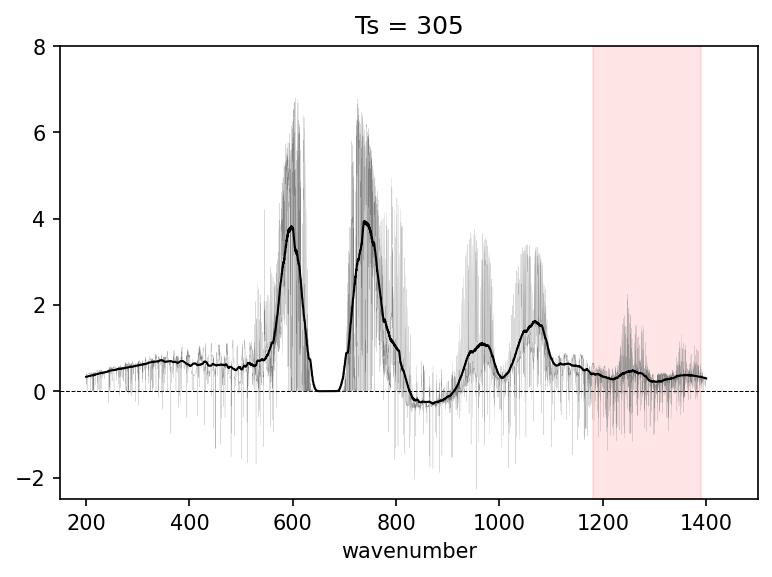

In [151]:
temp = 305

fig, ax = plt.subplots(dpi=150)

(rfm_lambdanu.sel(Ts=temp)*1000).sel(wavenumber=slice(200, 1400)).plot(ax=ax, lw=0.07, alpha=1, color='grey')
(rfm_lambdanu.sel(Ts=temp)*1000).rolling(wavenumber=300, center=True).mean().sel(wavenumber=slice(200, 1400)).plot(ax=ax, lw=1, alpha=1, color='black')

ax.hlines(y=0, xmin=150, xmax=1500, linestyle='--', color='black', lw=0.5)
ax.set_xlim(150, 1500)

ax.fill_betweenx(y=np.linspace(-2.5, 8), x1=1285-210/2, x2=1285+210/2, color='red', alpha=0.1)
ax.set_ylim(-2.5, 8)

In [51]:
rfm_lambda_bands = xr.DataArray(dims=['Ts', 'band'], coords={'Ts': np.arange(280, 326), 'band':central_rrtmg_lw_bands})

for ts in np.arange(280, 326):
    for idx, nuband in enumerate(central_rrtmg_lw_bands):
        rfm_lambda_bands.loc[dict(Ts=ts, band=nuband)] = rfm_lambdanu.loc[dict(Ts=ts)].sel(wavenumber=slice(nuband-delwave[idx]/2, nuband+delwave[idx]/2)).integrate('wavenumber')

In [48]:
rfm_lambda_bands

<xarray.DataArray (Ts: 46, band: 16)>
array([[1.38189020e-04, 3.96137268e-04, 7.51294554e-04, 2.09498627e-03,
        2.95707239e-03, 3.75763130e-03, 3.54369701e-03, 2.86957954e-03,
        1.04575824e-03, 1.16037610e-04, 4.84006206e-05, 9.88775257e-05,
        1.86735786e-04, 3.13212081e-05, 7.32504919e-05, 2.29629132e-05],
       [1.41521650e-04, 4.02205577e-04, 7.37377881e-04, 1.89122494e-03,
        2.85503061e-03, 3.70331025e-03, 3.53307489e-03, 2.86301802e-03,
        1.02189037e-03, 1.19277465e-04, 4.98745247e-05, 9.70076384e-05,
        1.89012130e-04, 2.60714076e-05, 7.55312893e-05, 2.37146404e-05],
       [1.46493028e-04, 4.10228456e-04, 7.44082162e-04, 1.63685832e-03,
        2.75810371e-03, 3.63820360e-03, 3.51497854e-03, 2.85159498e-03,
        9.96881649e-04, 1.22975937e-04, 5.16595646e-05, 9.50689294e-05,
        1.90776938e-04, 2.10065122e-05, 7.78359886e-05, 2.44685824e-05],
       [1.50493877e-04, 4.18107539e-04, 7.70841055e-04, 1.36000294e-03,
        2.66668716e-03, 3.56134895e-03, 3.48836212e-03, 2.83472568e-03,
        9.70489150e-04, 1.26620480e-04, 5.33573024e-05, 9.30373128e-05,
        1.91959224e-04, 1.62887345e-05, 8.01532950e-05, 2.52227481e-05],
       [1.54940276e-04, 4.26774818e-04, 8.15707407e-04, 1.09118589e-03,
        2.57981968e-03, 3.47179309e-03, 3.45206130e-03, 2.81178873e-03,
        9.42853930e-04, 1.30514050e-04, 5.52000858e-05, 9.09758753e-05,
        1.92513689e-04, 1.21479597e-05, 8.24714252e-05, 2.59751819e-05],
...
       [4.02889982e-04, 4.85310136e-04, 2.75856667e-03, 7.31050944e-05,
        3.51667775e-03, 3.78247626e-04, 1.10524342e-03, 8.83087868e-05,
        3.79318789e-04, 3.26163922e-04, 1.70195139e-04, 1.27003384e-04,
        1.32034590e-04, 4.19260505e-07, 1.11750155e-04, 2.67264693e-05],
       [4.00515990e-04, 4.63402830e-04, 2.82716747e-03, 8.83426166e-05,
        3.61381637e-03, 4.11070309e-04, 1.14489190e-03, 9.62261845e-05,
        3.86305053e-04, 3.26369462e-04, 1.70522059e-04, 1.28114628e-04,
        1.33957578e-04, 4.84692833e-07, 1.10153464e-04, 2.57141872e-05],
       [3.98338158e-04, 4.41460507e-04, 2.89324399e-03, 1.06429229e-04,
        3.70796870e-03, 4.45159709e-04, 1.18409198e-03, 1.04902483e-04,
        3.93315931e-04, 3.26300934e-04, 1.70664337e-04, 1.29079229e-04,
        1.35850738e-04, 5.61072349e-07, 1.08475387e-04, 2.47028407e-05],
       [3.94234355e-04, 4.18692690e-04, 2.95726203e-03, 1.28722840e-04,
        3.79974632e-03, 4.81242474e-04, 1.22303295e-03, 1.14727043e-04,
        4.00229207e-04, 3.25607455e-04, 1.70270283e-04, 1.29914311e-04,
        1.37656125e-04, 6.51478315e-07, 1.06747741e-04, 2.37107477e-05],
       [3.88578015e-04, 3.95336619e-04, 3.01851807e-03, 1.56560956e-04,
        3.88790173e-03, 5.17570688e-04, 1.26051827e-03, 1.24627561e-04,
        4.06732224e-04, 3.24349523e-04, 1.69396373e-04, 1.30555713e-04,
        1.39293641e-04, 7.58842522e-07, 1.04985116e-04, 2.27466166e-05]])
Coordinates:
  * Ts       (Ts) int64 280 281 282 283 284 285 286 ... 320 321 322 323 324 325
  * band     (band) int64 180 425 565 665 760 900 ... 1940 2165 2315 2490 2925

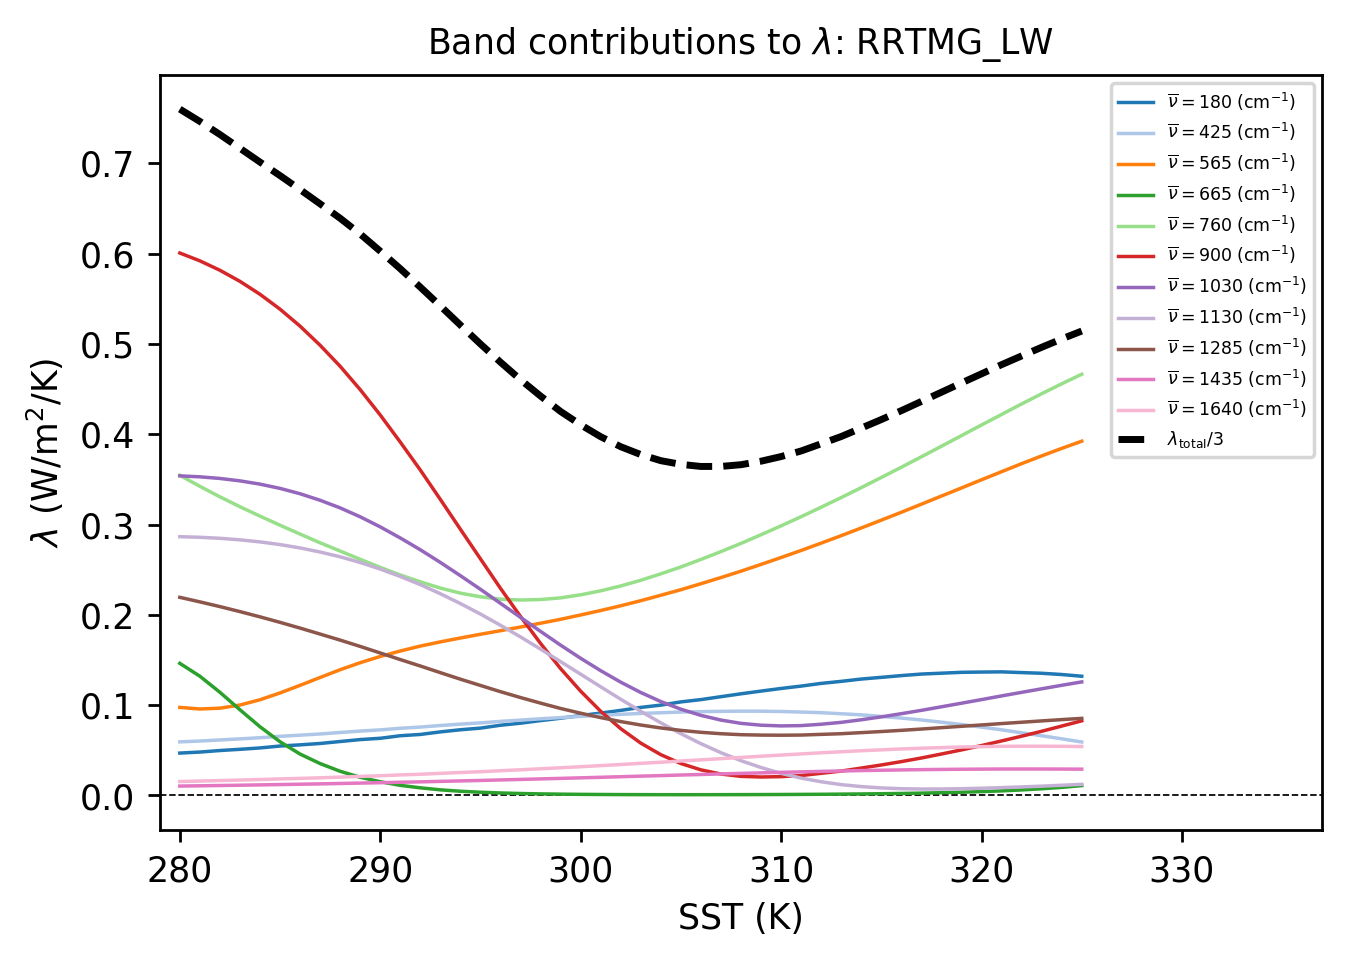

In [68]:
fig, ax = plt.subplots(dpi=250, figsize=(6,4))

n=len(central_rrtmg_lw_bands)
colors = plt.cm.tab20(np.linspace(0,1,n)) # Set1

for i in range(n)[:11]:
    string = fr"$\overline{{\nu}}=${central_rrtmg_lw_bands[i]} (cm$^{{-1}}$)"   # + fr"$\Delta\nu=${delwave[i]} (cm$^{{-1}}$)" #+ "\n" +
    ax.plot(np.arange(280, 326), rfm_lambda_bands[:,i], color=colors[i], label=string, lw=1)

_ = (rfm_lambda_bands.sum('band')/3).plot(ax=ax, color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$/3')

ax.set_xlabel(r"SST (K)")
ax.set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")

ax.set_title(r"Band contributions to $\lambda$: RRTMG_LW", fontsize=10)

ax.hlines(y=0, xmin=279, xmax=337, linestyle='--', color='k', lw=0.5)
ax.set_xlim(279, 337)
ax.legend(loc='upper right', prop={'size': 5})

#plt.savefig("./Figs/lambda_band_contributions_with_total.png", dpi=400, facecolor='white', bbox_inches='tight')

# Now, for RRTMG_LW

In [54]:
C_Ts = xr.open_dataarray("./Data/C_Ts_curve_RRTMG_p01_imbalance.nc")
Ts_C = xr.open_dataarray("./Data/Ts_C_curve_RRTMG_p01_imbalance.nc")

In [55]:
TEMPS = np.linspace(280, 320, 41)
rrtm_lambda_sr = xr.DataArray(np.empty((len(TEMPS), len(central_rrtmg_lw_bands))), dims=['Ts', 'wavenumber'], 
                              coords={'Ts':xr.DataArray(TEMPS, dims=['Ts'], attrs={'units':'K'}), 
                              'wavenumber':xr.DataArray(central_rrtmg_lw_bands, dims=['wavenumber'], attrs={'units':'cm-1'})},
                              attrs={'standard_name':'Spectrally-resolved feedback parameter', 'units': 'W/m2/K/cm-1'})

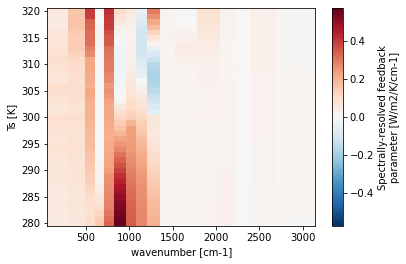

In [58]:
for temp in rrtm_lambda_sr.Ts:
    conc = C_Ts.sel(Ts=temp)
    rrtm_lambda_sr.loc[dict(Ts=temp)] = calc_olr(SST=temp.values+1,CO2ppmv=conc.values)[1][0] - calc_olr(SST=temp.values,CO2ppmv=conc.values)[1][0]
    

rrtm_lambda_sr.plot()

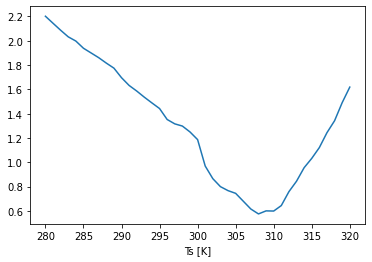

In [59]:
rrtm_lambda_sr.sum('wavenumber').plot()

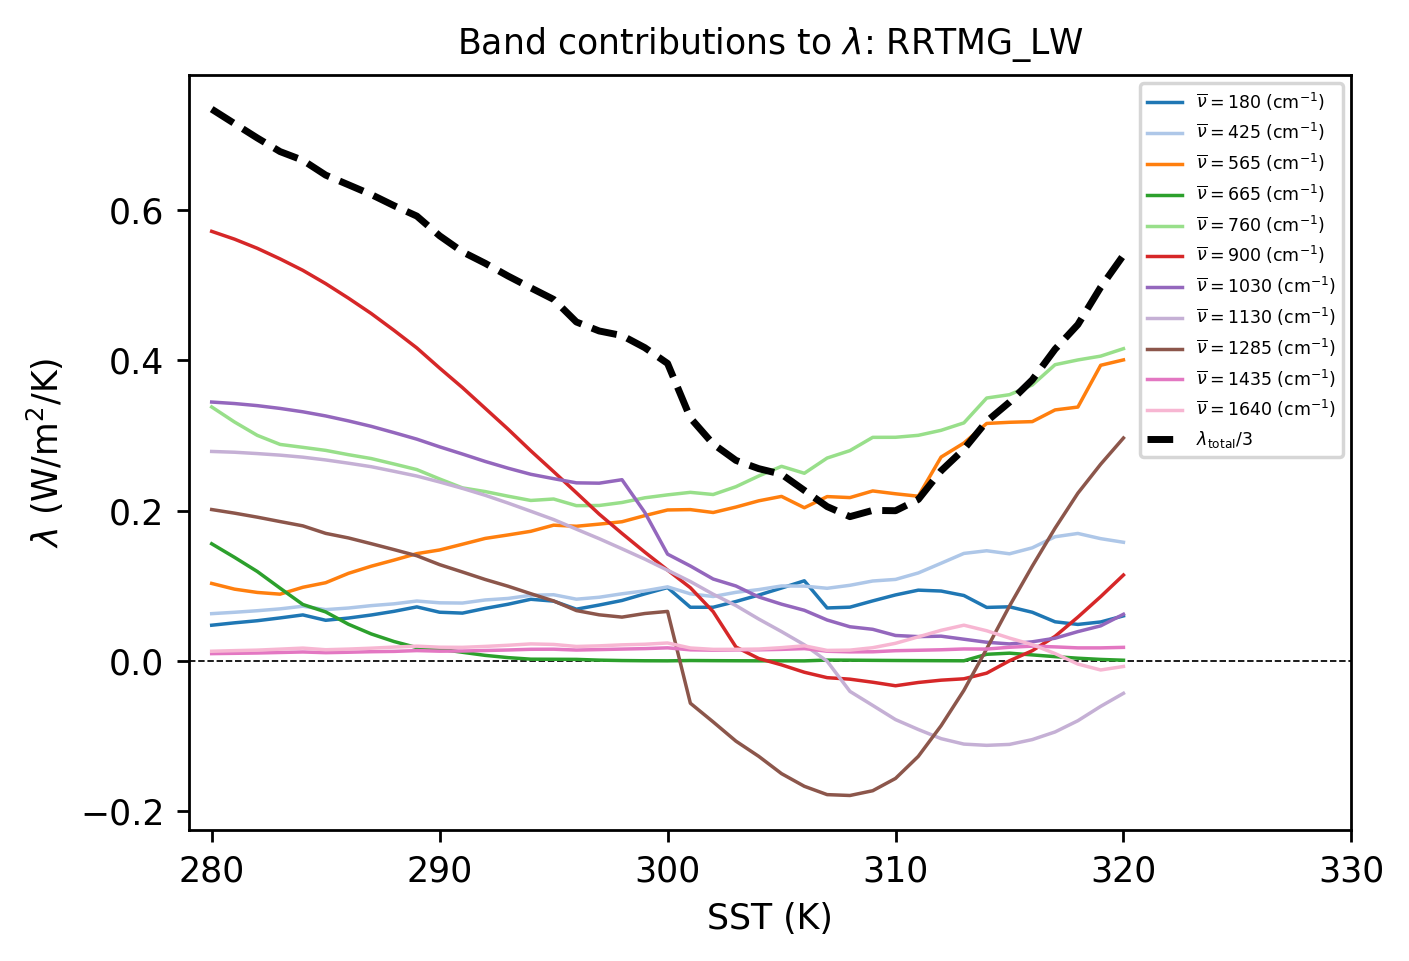

In [63]:
fig, ax = plt.subplots(dpi=250, figsize=(6,4))

n=len(central_rrtmg_lw_bands)
colors = plt.cm.tab20(np.linspace(0,1,n)) # Set1

for i in range(n)[:11]:
    string = fr"$\overline{{\nu}}=${central_rrtmg_lw_bands[i]} (cm$^{{-1}}$)"   # + fr"$\Delta\nu=${delwave[i]} (cm$^{{-1}}$)" #+ "\n" +
    ax.plot(np.arange(280, 321), rrtm_lambda_sr[:,i], color=colors[i], label=string, lw=1)

_ = (rrtm_lambda_sr.sum('wavenumber')/3).plot(ax=ax, color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$/3')

ax.set_xlabel(r"SST (K)")
ax.set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")

ax.set_title(r"Band contributions to $\lambda$: RRTMG_LW", fontsize=10)

ax.hlines(y=0, xmin=279, xmax=330, linestyle='--', color='k', lw=0.5)
ax.set_xlim(279, 330)
ax.legend(loc='best', prop={'size': 5})

#plt.savefig("./Figs/lambda_band_contributions_with_total.png", dpi=400, facecolor='white', bbox_inches='tight')

# RRTMG-RFM

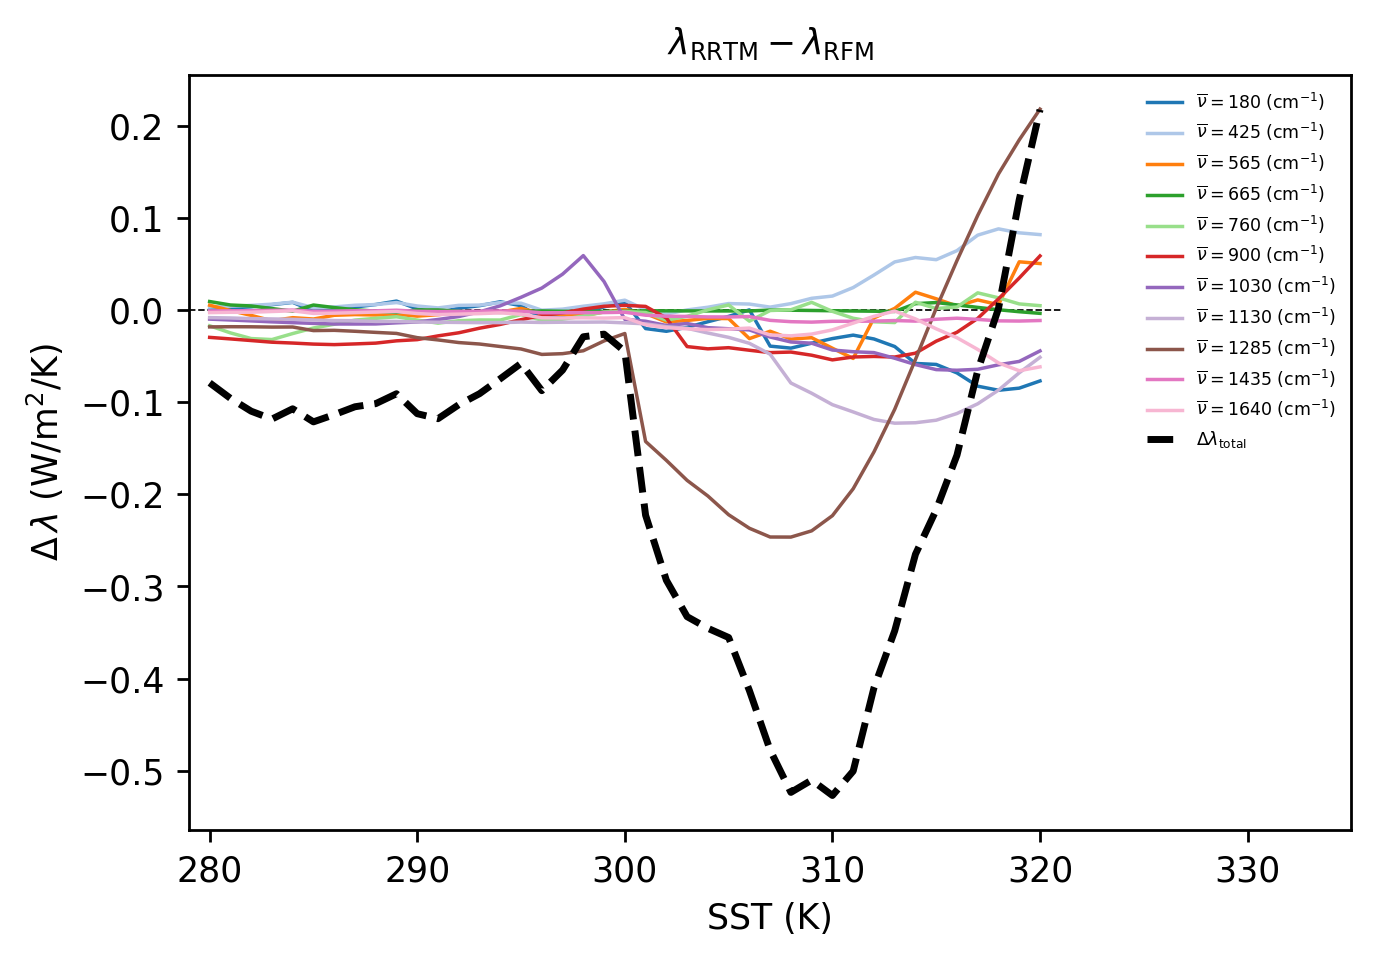

In [86]:
fig, ax = plt.subplots(dpi=250, figsize=(6,4))

n=len(central_rrtmg_lw_bands)
colors = plt.cm.tab20(np.linspace(0,1,n)) # Set1

for i in range(n)[:11]:
    string = fr"$\overline{{\nu}}=${central_rrtmg_lw_bands[i]} (cm$^{{-1}}$)" 
    ax.plot(np.arange(280, 321), rrtm_lambda_sr[:,i]-rfm_lambda_bands[:-5,i], color=colors[i], label=string, lw=1)

_ = (rrtm_lambda_sr.sum('wavenumber')-rfm_lambda_bands.sum('band').sel(Ts=slice(280, 320))).plot(ax=ax, color='black', lw=2, 
                                                                                                 linestyle='--', 
                                                                                                 label=r'$\Delta\lambda_{\mathrm{total}}$')


ax.set_xlabel(r"SST (K)")
ax.set_ylabel(r"$\Delta \, \lambda$ (W/m$^{2}$/K)")

ax.set_title(r"$\lambda_{\mathrm{RRTM}}-\lambda_{\mathrm{RFM}}$", fontsize=10)

ax.hlines(y=0, xmin=279, xmax=321, linestyle='--', color='k', lw=0.5)
ax.set_xlim(279, 335)
ax.legend(loc='upper right', frameon=False, prop={'size': 5})

#plt.savefig("./Figs/lambda_band_contributions_with_total.png", dpi=400, facecolor='white', bbox_inches='tight')

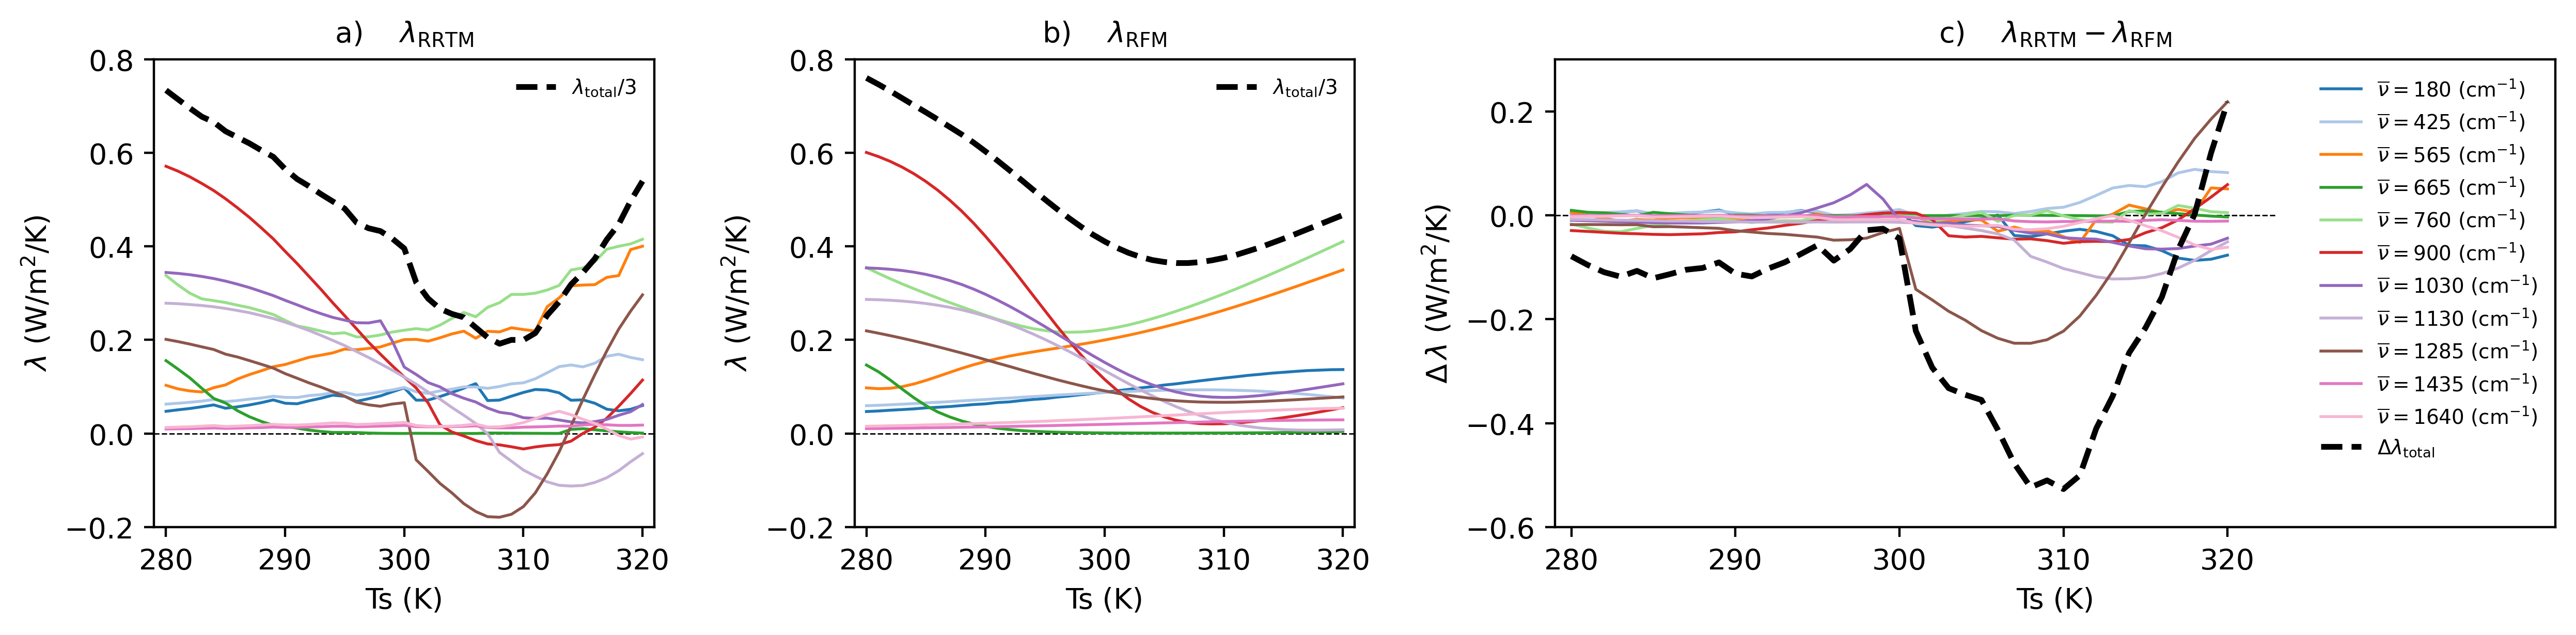

In [145]:
fig, axs = plt.subplots(ncols=3, dpi=400, figsize=(15,3), gridspec_kw={'width_ratios':[1,1,2]})

n=len(central_rrtmg_lw_bands)
colors = plt.cm.tab20(np.linspace(0,1,n)) # Set1

""" RRTMG """
for i in range(n)[:11]:  
    axs[0].plot(np.arange(280, 321), rrtm_lambda_sr[:,i], color=colors[i], lw=1)

l1 = (rrtm_lambda_sr.sum('wavenumber')/3).plot(ax=axs[0], color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$/3')
axs[0].legend(frameon=False, prop={'size': 7})

""" RFM """

for i in range(n)[:11]:
    axs[1].plot(np.arange(280, 321), rfm_lambda_bands[:-5,i], color=colors[i], lw=1)

l2 = (rfm_lambda_bands.sum('band')/3).sel(Ts=slice(280,320)).plot(ax=axs[1], color='black', lw=2, linestyle='--', label=r'$\lambda_{\mathrm{total}}$/3')
axs[1].legend(frameon=False, prop={'size': 7})

""" RRTMG-RFM """
for i in range(n)[:11]:
    string = fr"$\overline{{\nu}}=${central_rrtmg_lw_bands[i]} (cm$^{{-1}}$)" 
    axs[2].plot(np.arange(280, 321), rrtm_lambda_sr[:,i]-rfm_lambda_bands[:-5,i], color=colors[i], label=string, lw=1)

_ = (rrtm_lambda_sr.sum('wavenumber')-rfm_lambda_bands.sum('band').sel(Ts=slice(280, 320))).plot(ax=axs[2], color='black', lw=2, 
                                                                                                 linestyle='--', 
                                                                                                 label=r'$\Delta\lambda_{\mathrm{total}}$')


axs[2].set_xlabel(r"SST (K)")

axs[0].set_title(r"a)    $\lambda_{\mathrm{RRTM}}$", fontsize=10)
axs[1].set_title(r"b)    $\lambda_{\mathrm{RFM}}$", fontsize=10)
axs[2].set_title(r"c)    $\lambda_{\mathrm{RRTM}}-\lambda_{\mathrm{RFM}}$", fontsize=10)

for ax in axs:
    ax.hlines(y=0, xmin=279, xmax=321, linestyle='--', color='k', lw=0.5)
    ax.set_xlim(279, 321)
    ax.set_xlabel("Ts (K)")
    ax.set_ylim(-0.2, 0.8)
    
axs[0].set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")
axs[1].set_ylabel(r"$\lambda$ (W/m$^{2}$/K)")
axs[2].set_ylabel(r"$\Delta \, \lambda$ (W/m$^{2}$/K)")

axs[2].hlines(y=0, xmin=279, xmax=323, linestyle='--', color='k', lw=0.5)
axs[2].set_xlim(279, 340)
axs[2].legend(loc='upper right', frameon=False, prop={'size': 7})
axs[2].set_ylim(-0.6, 0.3)

axs[2].set_xticks([280, 290, 300, 310, 320])

fig.subplots_adjust(wspace=0.3)
#plt.savefig("./Figs/lambda_band_RRTM_vs_RFM.png", dpi=400, facecolor='white', bbox_inches='tight')